# Package import and Data Loading

100%|██████████| 170M/170M [00:03<00:00, 48.1MB/s]


torch.Size([64, 3, 32, 32]) torch.Size([64])


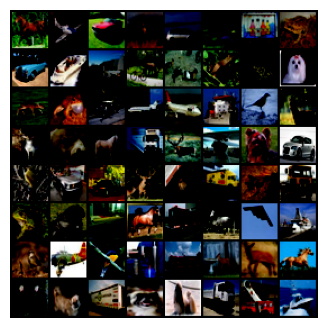

CIFAR-10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import GaussianBlur
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
# from utils import *


batch_size = 64

# Define transform — converts to tensor and normalizes RGB values
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor [0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize RGB channels
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize a batch
x, y = next(iter(train_loader))
print(x.shape, y.shape)   # Expected: torch.Size([64, 3, 32, 32])

# Convert grid of images to numpy for plotting
npimg = torchvision.utils.make_grid(x).numpy()
plt.figure(figsize=(8, 4))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis('off')
plt.show()

# Print class names
print("CIFAR-10 classes:", train_dataset.classes)


# Model Definition, Running and Results:

In [3]:
# Hyperparameters
learning_rate = 0.001
epochs = 10

# ---- Model without BatchNorm ----
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(

            nn.Conv2d(3, 16, kernel_size= 5, padding= 2, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2), # -> (64, 4, 4)
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(64*4*4, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

# ---- Model with BatchNorm ----
class NN_BN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(

            nn.Conv2d(3, 16, kernel_size= 5, padding= 2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2), # -> (64, 4, 4)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(64*4*4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)


criterion = nn.CrossEntropyLoss()

model_no_bn = NN()
optimizer_1 = torch.optim.SGD(model_no_bn.parameters(), lr=learning_rate)

model_bn = NN_BN()
optimizer_2 = torch.optim.SGD(model_bn.parameters(), lr=learning_rate)


In [14]:
# Train model without BatchNorm
batch_sizes = [8, 32, 128, 256]
loss_across_batch_no_bn = list()
accuracy_across_batch_no_bn = list()

for batch_size in batch_sizes:
  print(f"######## TRAINING FOR BATCH SIZE: {batch_size} ###################")
  model_no_bn = NN()
  optimizer_1 = torch.optim.SGD(model_no_bn.parameters(), lr=learning_rate)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  # Train model without BatchNorm with Adam
  loss_no_bn, acc_no_bn = train_model(model_no_bn, optimizer_1, criterion,
                                      train_loader, test_loader, epochs)
  loss_across_batch_no_bn.append(np.mean(loss_no_bn))
  accuracy_across_batch_no_bn.append(np.mean(acc_no_bn))


######## TRAINING FOR BATCH SIZE: 8 ###################


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

######## TRAINING FOR BATCH SIZE: 32 ###################


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

######## TRAINING FOR BATCH SIZE: 128 ###################


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

######## TRAINING FOR BATCH SIZE: 256 ###################


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

In [15]:
# Train model with BatchNorm
loss_across_batch_bn = list()
accuracy_across_batch_bn = list()

for batch_size in batch_sizes:
  print(f"######## TRAINING FOR BATCH SIZE: {batch_size} ###################")

  model_bn = NN_BN()
  optimizer_2 = torch.optim.SGD(model_bn.parameters(), lr=learning_rate)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  # Train model with BatchNorm with Adam
  loss_bn, acc_bn = train_model(model_bn, optimizer_2, criterion, train_loader,
                                test_loader, epochs)

  loss_across_batch_bn.append(np.mean(loss_bn))
  accuracy_across_batch_bn.append(np.mean(acc_bn))


######## TRAINING FOR BATCH SIZE: 8 ###################


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Training batches:   0%|          | 0/6250 [00:00<?, ?it/s]

######## TRAINING FOR BATCH SIZE: 32 ###################


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

######## TRAINING FOR BATCH SIZE: 128 ###################


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

######## TRAINING FOR BATCH SIZE: 256 ###################


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

Training batches:   0%|          | 0/196 [00:00<?, ?it/s]

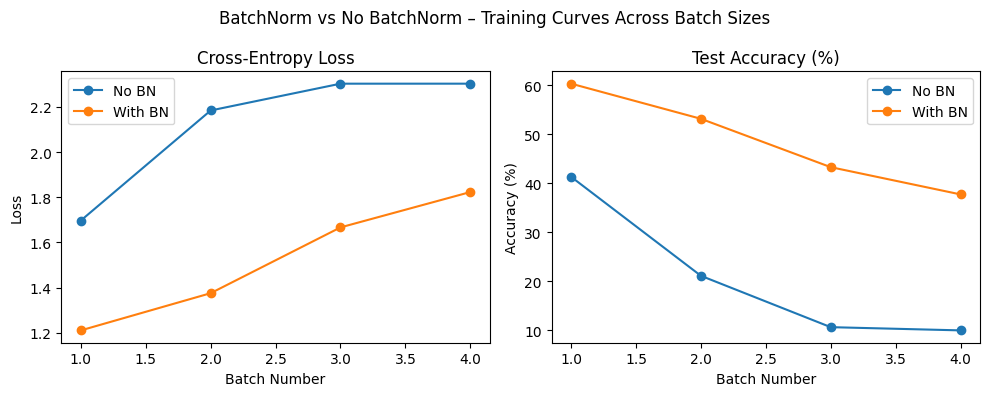

In [16]:
plot_compare_training_batch_curves(
    loss_bn=loss_across_batch_bn,
    loss_no_bn=loss_across_batch_no_bn,
    acc_bn=accuracy_across_batch_bn,
    acc_no_bn=accuracy_across_batch_no_bn,
    batch_number=len(batch_sizes)
)


In [13]:
model_no_bn = NN()
optimizer_1 = torch.optim.SGD(model_no_bn.parameters(), lr=learning_rate)

model_bn = NN_BN()
optimizer_2 = torch.optim.SGD(model_bn.parameters(), lr=learning_rate)

In [8]:
# Train model with BatchNorm with Adam and without eval_activated

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

_ , acc_bn_no_eval_2 = train_model(model_bn, optimizer_2, criterion,
                                              train_loader, test_loader, epochs = 10,
                                              eval_status = False)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

In [9]:
model_bn = NN_BN()
optimizer_2 = torch.optim.SGD(model_bn.parameters(), lr=learning_rate)

In [10]:
# Train model with BatchNorm with Adam and with eval_activated

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

_ , acc_bn_eval_2 = train_model(model_bn, optimizer_2, criterion,
                                        train_loader, test_loader, epochs = 10)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

Training batches:   0%|          | 0/391 [00:00<?, ?it/s]

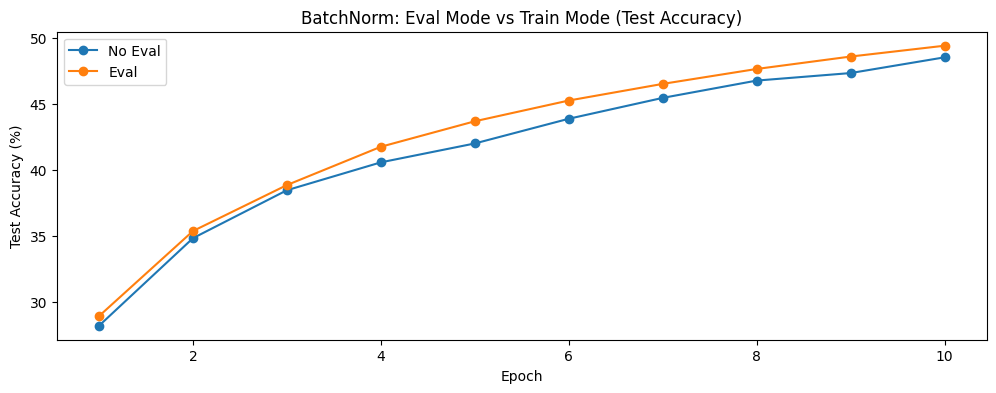

In [11]:
plot_compare_training_eval_curves(
    acc_eval=acc_bn_eval_2,
    acc_no_eval=acc_bn_no_eval_2,
    epochs=10
)

In [17]:
model_no_bn = NN()
optimizer_1 = optim.Adam(model_no_bn.parameters(), lr=learning_rate)

model_bn = NN_BN()
optimizer_2 = optim.Adam(model_bn.parameters(), lr=learning_rate)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

_ , _ = train_model(model_no_bn, optimizer_1, criterion,
                                        train_loader, test_loader, epochs = 10)

_ , _ = train_model(model_bn, optimizer_2, criterion,
                                        train_loader, test_loader, epochs = 10)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training batches:   0%|          | 0/782 [00:00<?, ?it/s]

In [60]:
# Obtention of dead neuron statistics.

acts_no_bn = get_all_relu_activations(model_no_bn, train_loader)
acts_bn = get_all_relu_activations(model_bn, train_loader)

In [58]:
dead_no_bn_list = []
dead_bn_list = []
avg_zero_no_bn_list = []
avg_zero_bn_list = []

for layer_idx in acts_no_bn:
    dead_no_bn, avg_zero_no_bn = count_dead_neurons(
        acts_no_bn[layer_idx])

    dead_no_bn_list.append(dead_no_bn)
    avg_zero_no_bn_list.append(avg_zero_no_bn)

for layer_idx in acts_bn:

    dead_bn, avg_zero_bn = count_dead_neurons(
        acts_bn[layer_idx])
    dead_bn_list.append(dead_bn)
    avg_zero_bn_list.append(avg_zero_bn)

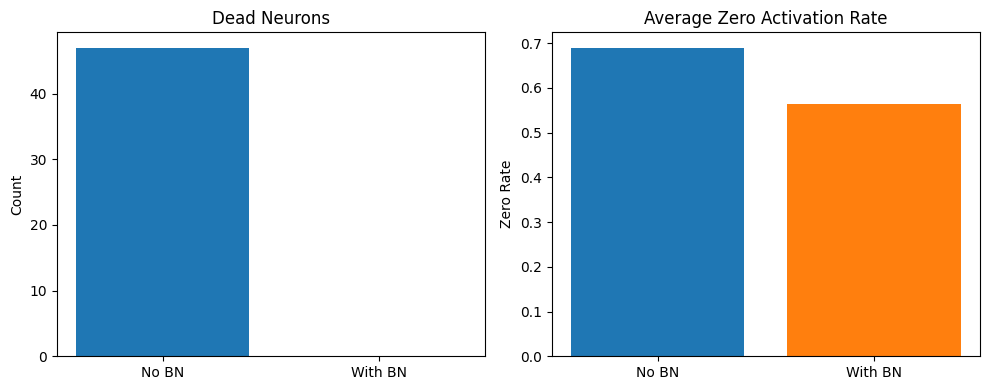

In [59]:
dead_neuron_plot(np.sum(dead_no_bn_list), np.mean(avg_zero_no_bn_list), np.sum(dead_bn_list), np.mean(avg_zero_bn_list))